# **Classifying Cats and Dogs using CNN (Transfer Learning)**

## **1. Problem Statement : Build a Convolutional Neural Network (CNN) model to classify images as either containing a cat or dog.**

## **2. Import Libraries**

In [1]:
#=================================================================
# For data manipulation, plotting, and miscellaneous
#=================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import calendar
from datetime import datetime

from PIL import Image
import cv2  # For Image processing
#===============================================================================================
# Import Keras models, layers, activation functions
#===============================================================================================
import tensorflow as tf
tf.random.set_seed(3)
import keras
from keras import datasets, models
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, ReLU, LeakyReLU, Dropout
from keras import regularizers
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16
#=================================================================
# From sklearn import required classes
#=================================================================
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report

## **3. Import the Dataset**

**Here we using keras generator in order to load the images in terms of batches, because loading all those thousands of images in to the RAM is impossible, so we are using "Generators" concept in python to load images in batches**

https://keras.io/api/data_loading/image/

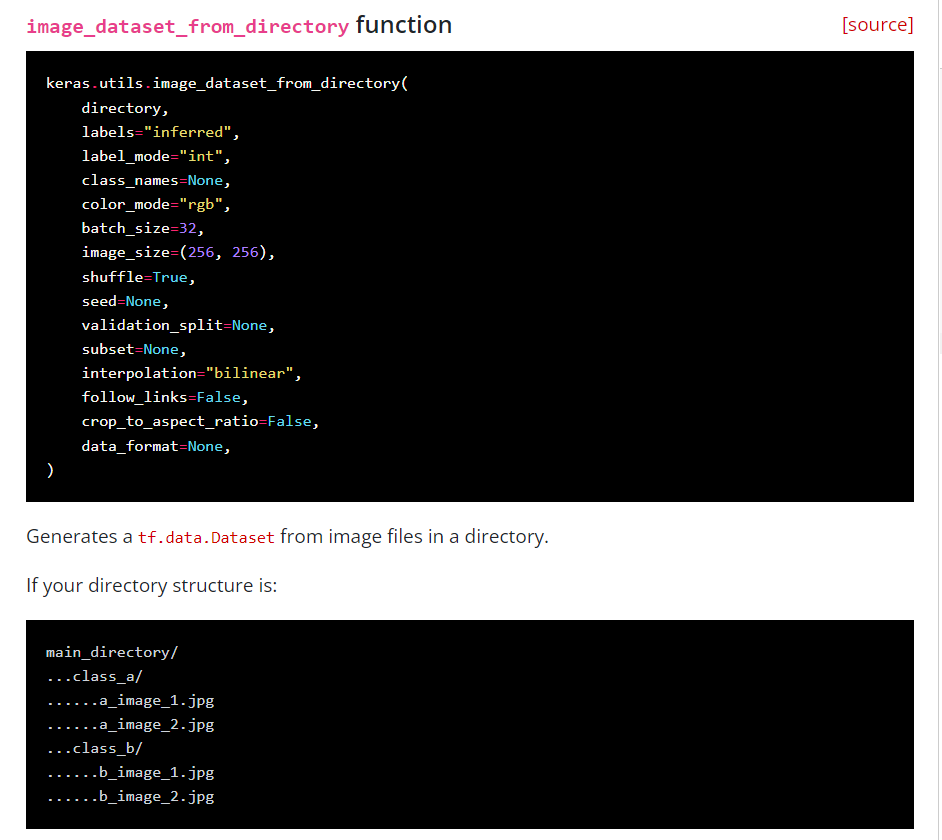

### **3.1. Creating Training and Validation data generators**

In [2]:
img_width, img_height = 150,150    # width and height of the images
img_ch = 3                         # Image color channels - RGB - 3 color channels
train_data_dir = r"./train"
validation_data_dir=r"./test"
batch_size = 32

In [3]:
# training dataset generator
train_ds = keras.utils.image_dataset_from_directory(
    directory = train_data_dir,         # Directory where the data is located
    labels = 'inferred',                # "inferred" (labels are generated from the directory structure),
    label_mode = 'int',                 # "int": means that the labels are encoded as integers (0,1,2,3..).
    batch_size=batch_size,              # Size of the batches of data. Defaults to 32. If None, the data will not be batched (the dataset will yield individual samples).
    image_size=(img_width,img_height)   # Size to resize images to after they are read from disk, specified as (height, width). Defaults to (256, 256).
)

Found 20000 files belonging to 2 classes.


In [4]:
# validation dataset generator
validation_ds = keras.utils.image_dataset_from_directory(
    directory = validation_data_dir,        # Directory where the data is located
    labels = 'inferred',                    # "inferred" (labels are generated from the directory structure),
    label_mode = 'int',                     # "int": means that the labels are encoded as integers (0,1,2,3..).
    batch_size=batch_size,                  # Size of the batches of data. Defaults to 32. If None, the data will not be batched (the dataset will yield individual samples).
    image_size=(img_width,img_height)       # Size to resize images to after they are read from disk, specified as (height, width). Defaults to (256, 256).
)

Found 5000 files belonging to 2 classes.


**Cat : 0**

**Dog : 1**

### **3.2. Normalize the Data**

In [5]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

### **3.3. Visualize the Data**

**Cat : 0**

**Dog : 1**

**1. Plot Images from a Single batch**

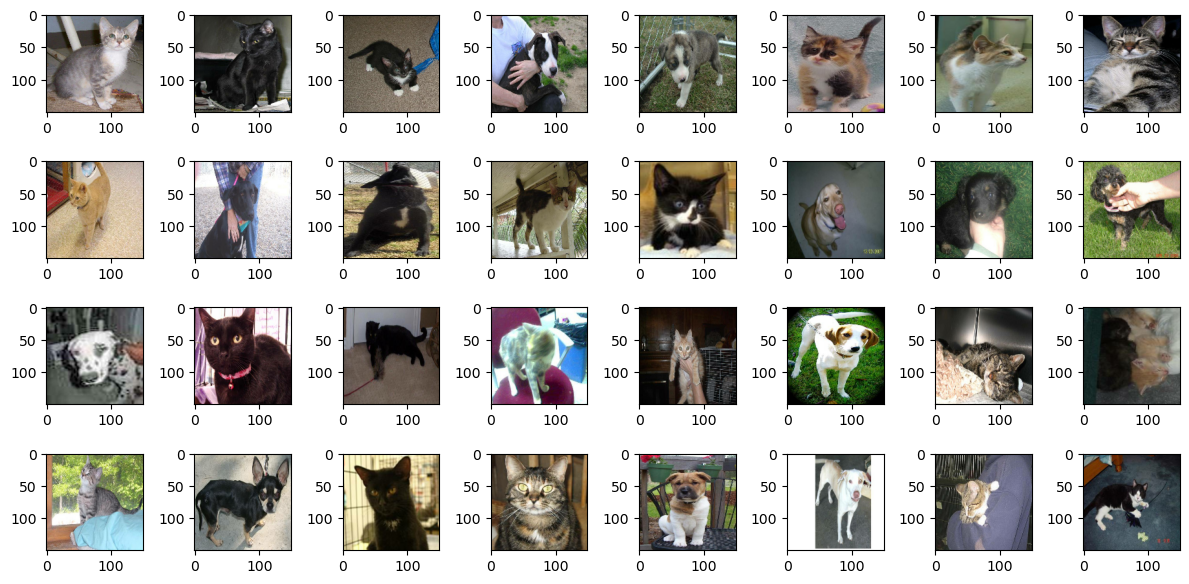

In [6]:
# 1. Plot Images from a Single batch
plt.figure(figsize=(12, 6))
for X_batch, Y_batch in train_ds:    # select ONLY ONE batch using train_generator
    for i in range(0,32):            # plot all images from that batch by using this "for" loop
        image = X_batch[i]
        plt.subplot(4, 8, i+1)
        plt.imshow(image)
    break
plt.tight_layout()
plt.show()

In [7]:
Y_batch    # single batch consists of 32 images as mentioned in the batch size parameter above

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0])>

In [8]:
X_batch[0].shape

TensorShape([150, 150, 3])

**2. Plot Images from mutiple batches**

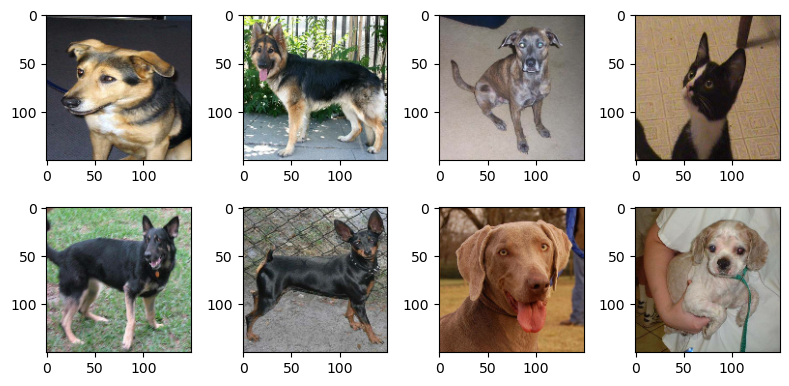

In [9]:
# 2. Plot Images from mutiple batches
plt.figure(figsize=(8, 4))
for i in range(0, 8):                   # For loop will run for 8 times to call 8 batches
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in train_ds:   # select ONE batch using train_generator
        image = X_batch[0]              # plot only 1st image from respective batch
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [10]:
Y_batch   # this is from the last batch, which consists of 32 images

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1])>

## **4. Build CNN Model**

### **4.1. Create CNN Model**

In [11]:
input_image_shape = (img_width, img_height,img_ch)   # image size
l2reg_val = 1e-5  # for l2- regularization

#================================================================
# create model
model = Sequential()

#================================================================
# Step #1 : Feature Extraction
#================================================================
# Convolutional layer #1
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_image_shape, name='Conv2D_1' ))
                                                             # output shape will be : (n-f+2p)/s+1, here f=kernel size=3
model.add(BatchNormalization(name='BatchNorm_1'))            # to make training of NN faster and more stable
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_1')) # output shape will be : (n-f+2p)/s+1 , here f=pool size=2

# Convolutional layer #2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_2'))
model.add(BatchNormalization(name='BatchNorm_2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_2'))

# Convolutional layer #3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(BatchNormalization(name='BatchNorm_3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_3'))

#================================================================
# Step # 2 : Image Classification
#================================================================
# fully connected layer
model.add(Flatten(name='Flatten'))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(l2reg_val), name = 'Dense_1'))
#model.add(BatchNormalization(name='BatchNorm_4'))
#model.add(Dropout(0.2, name='Dropout_1'))                                       # to avoid overfitting

model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(l2reg_val), name = 'Dense_2'))
#model.add(BatchNormalization(name='BatchNorm_5'))
#model.add(Dropout(0.2, name='Dropout_2'))                                       # to avoid overfitting

model.add(Dense(1, activation='sigmoid', name = 'Output'))   # sigmoid for binary class classification, we have 2 classes
#================================================================

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 150, 150, 32)     128       
 tion)                                                           
                                                                 
 Maxpool_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 BatchNorm_2 (BatchNormaliza  (None, 75, 75, 64)       256       
 tion)                                                           
                                                                 
 Maxpool_2 (MaxPooling2D)    (None, 37, 37, 64)        0

### **4.2. Compile the model**

In [12]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

### **4.3. Train the Model**

In [13]:
epoch = 10

earlystop = EarlyStopping(monitor='val_accuracy', patience = 4, min_delta = 0.01, mode='max')

#===========================================================================================================
training = model.fit(train_ds, validation_data = validation_ds, epochs = epoch, callbacks = [earlystop] )

Epoch 1/10
625/625 [==============================] - 37s 49ms/step - loss: 0.5888 - accuracy: 0.6833 - val_loss: 0.5401 - val_accuracy: 0.7264
Epoch 2/10
625/625 [==============================] - 31s 49ms/step - loss: 0.4592 - accuracy: 0.7840 - val_loss: 0.5059 - val_accuracy: 0.7482
Epoch 3/10
625/625 [==============================] - 31s 49ms/step - loss: 0.3824 - accuracy: 0.8360 - val_loss: 0.4922 - val_accuracy: 0.7618
Epoch 4/10
625/625 [==============================] - 31s 49ms/step - loss: 0.3194 - accuracy: 0.8713 - val_loss: 0.4817 - val_accuracy: 0.7670
Epoch 5/10
625/625 [==============================] - 31s 49ms/step - loss: 0.2670 - accuracy: 0.9036 - val_loss: 0.4715 - val_accuracy: 0.7772
Epoch 6/10
625/625 [==============================] - 30s 49ms/step - loss: 0.2200 - accuracy: 0.9291 - val_loss: 0.4727 - val_accuracy: 0.7782
Epoch 7/10
625/625 [==============================] - 30s 48ms/step - loss: 0.1803 - accuracy: 0.9492 - val_loss: 0.4830 - val_accuracy:

### **4.4. Save the Trained NN model**

In [14]:
model.save("DL_Cats_Dogs_Classification_CNN_Trained_Model_1.h5")

### **4.5. Plot the Accuracy and Loss history**

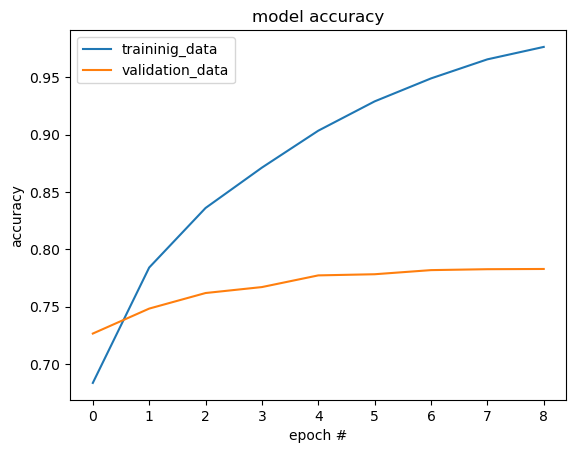

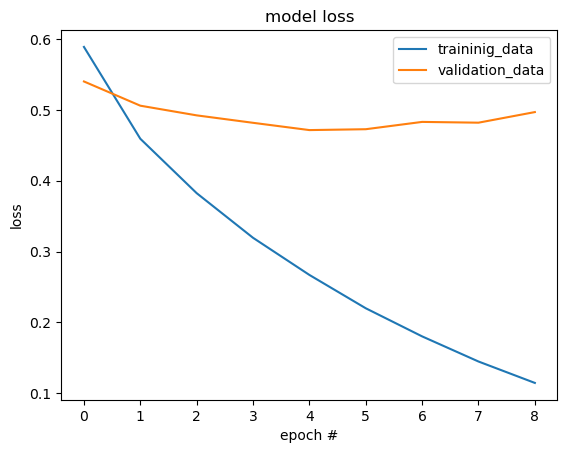

In [15]:
#============================================
# Plot the accuracy and loss curves 
#============================================
plt.plot(training.history['accuracy'], label='traininig_data')
plt.plot(training.history['val_accuracy'], label='validation_data')
plt.legend()
plt.title("model accuracy")
plt.xlabel("epoch #")
plt.ylabel("accuracy")
plt.show()

plt.plot(training.history['loss'], label='traininig_data')
plt.plot(training.history['val_loss'], label='validation_data')
plt.legend()
plt.title("model loss")
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.show()

### **4.6. Prediction for New Images**

In [16]:
from tensorflow.keras.preprocessing import image
img = image.load_img("./image1.png",target_size=(img_width, img_height))
img_pred = img

type(img_pred)

PIL.Image.Image

In [17]:
img_pred = image.img_to_array(img_pred)  # convert from PIL image type to numpy array
print(img_pred.shape)

(150, 150, 3)


In [18]:
img_pred=np.expand_dims(img_pred, axis=0)   # since we are predicting for 1 image, hence we need to reshape the input to the model as expected by model
print(img_pred.shape)

(1, 150, 150, 3)


1/1 [==============================] - 0s 172ms/step
[[0.01896548]]
              Prediction:  Cat


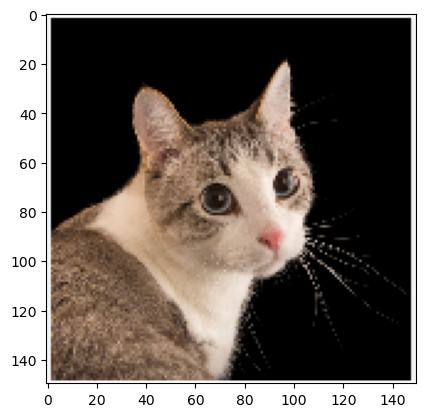

In [19]:
class_predict = model.predict(img_pred)    # predict the class
print(class_predict)

if class_predict[0][0]==1:
    prediction ="Dog"
else:
    prediction ="Cat"

print("=============================================")
print('              Prediction: ',prediction)
print("=============================================")

imgplot = plt.imshow(img)
plt.show()

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 15ms/step
[[1.]]
              Prediction:  Dog


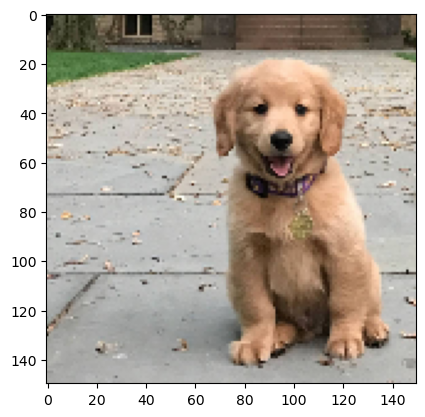

In [20]:
# put all commands at one place 
from tensorflow.keras.preprocessing import image
img = image.load_img("./image2.png",target_size=(img_width, img_height))
img_pred = img

type(img_pred)

img_pred = image.img_to_array(img_pred)  # convert from PIL image type to numpy array
print(img_pred.shape)

img_pred=np.expand_dims(img_pred, axis=0)   # since we are predicting for 1 image, hence we need to reshape the input to the model as expected by model
print(img_pred.shape)

class_predict = model.predict(img_pred)     # predict the class
print(class_predict)

if class_predict[0][0]==1:
    prediction ="Dog"
else:
    prediction ="Cat"

print("=============================================")
print('              Prediction: ',prediction)
print("=============================================")

imgplot = plt.imshow(img)
plt.show()



## **5. Build CNN model using VGG16 pretrained model**

![alt text](https://i.imgur.com/EyeXqiB.png)

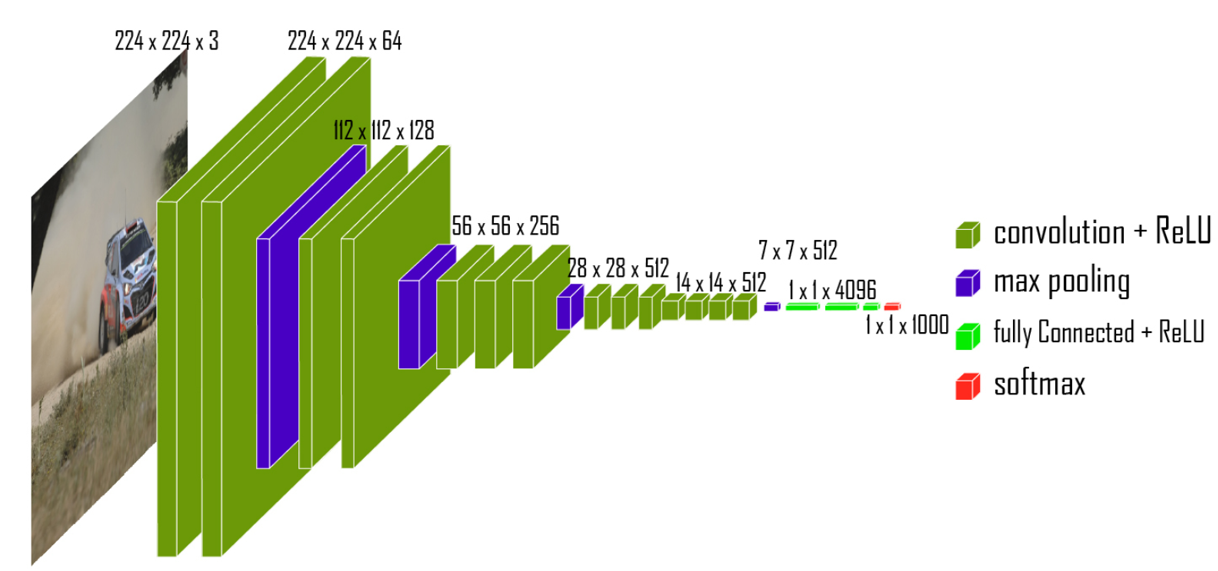

image source: Kaggle, and GeeksforGeeks

**The 16 in VGG16 refers to 16 layers that have weights. In VGG16 there are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.**

### **5.1. Check the shape of the image**

Two ways to represent the image data as a three dimensional array

1. <b>  Channels Last:<b> Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].

2.  <b> Channels First:<b> Image data is represented in a three-dimensional array where the first channel represents the color channels, e.g. [channels][rows][cols].


In [21]:
import tensorflow.keras.backend as k
if k.image_data_format()=='channels_first': 
    input_shape=(3, img_width, img_height)
else:
    input_shape=(img_width,img_height,3)
input_shape

(150, 150, 3)

### **5.2. Get the VGG16 convolutional base model**

In [22]:
# input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
# include_top: whether to include the 3 fully-connected layers at the top of the network.
# weights:"imagenet" (pre-training on ImageNet).

pretrained_conv_base = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
pretrained_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### **5.3. Set the trainable layers  in the VGG16 model**

In [23]:
# Check the type of layers in the pretrained model

print(type(pretrained_conv_base.layers))
print(type(pretrained_conv_base.layers[0]))
print(type(pretrained_conv_base.layers[1]))
print(type(pretrained_conv_base.layers[2]))
print(type(pretrained_conv_base.layers[3]))
print(type(pretrained_conv_base.layers[4]))

<class 'list'>
<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.pooling.max_pooling2d.MaxPooling2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>


In [24]:
# Check the layers names in the pretrained model

print(pretrained_conv_base.layers[0].name)
print(pretrained_conv_base.layers[1].name)
print(pretrained_conv_base.layers[2].name)

input_1
block1_conv1
block1_conv2


In [25]:
# we will use the pretrained model up to the layer block4_pool

pretrained_conv_base.layers[14].name   

'block4_pool'

In [26]:
# Here we are NOT training up to block4
for layer in pretrained_conv_base.layers[:15]:
    layer.trainable = False

# Training only block5
for layer in pretrained_conv_base.layers[15:]:
    layer.trainable = True

# check the summary of which layers will be trained
for layer in pretrained_conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


### **5.4. Create CNN Model based on VGG16**

In [27]:
l2reg_val = 1e-5  # for l2- regularization

#================================================================
# create model
model_vgg = Sequential()

#================================================================
# Step #1 : Feature Extraction
#================================================================
model_vgg.add(pretrained_conv_base)

#================================================================
# Step # 2 : Image Classification
#================================================================
# fully connected layer
model_vgg.add(Flatten(name='Flatten'))
model_vgg.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(l2reg_val), name = 'Dense_1'))
#model_vgg.add(Dropout(0.2, name='Dropout_1'))                                       # to avoid overfitting

model_vgg.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(l2reg_val), name = 'Dense_2'))
#model_vgg.add(Dropout(0.2, name='Dropout_2'))                                       # to avoid overfitting

model_vgg.add(Dense(1, activation='sigmoid', name = 'Output'))   # sigmoid for binary class classification, we have 2 classes
#================================================================

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 8192)              0         
                                                                 
 Dense_1 (Dense)             (None, 64)                524352    
                                                                 
 Dense_2 (Dense)             (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 15,243,265
Trainable params: 7,608,001
Non-trainable params: 7,635,264
_________________________________________________________________


### **5.5. Compile the model**

In [28]:
model_vgg.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

### **5.6. Train the Model**

In [29]:
epoch = 10

earlystop = EarlyStopping(monitor='val_accuracy', patience = 4, min_delta = 0.01, mode='max')

#===========================================================================================================
training = model_vgg.fit(train_ds, validation_data = validation_ds, epochs = epoch, callbacks = [earlystop] )

Epoch 1/10
625/625 [==============================] - 62s 93ms/step - loss: 0.2486 - accuracy: 0.8967 - val_loss: 0.1612 - val_accuracy: 0.9382
Epoch 2/10
625/625 [==============================] - 57s 91ms/step - loss: 0.1400 - accuracy: 0.9459 - val_loss: 0.1796 - val_accuracy: 0.9252
Epoch 3/10
625/625 [==============================] - 57s 91ms/step - loss: 0.1003 - accuracy: 0.9646 - val_loss: 0.1500 - val_accuracy: 0.9408
Epoch 4/10
625/625 [==============================] - 57s 91ms/step - loss: 0.0731 - accuracy: 0.9747 - val_loss: 0.1246 - val_accuracy: 0.9516
Epoch 5/10
625/625 [==============================] - 57s 91ms/step - loss: 0.0503 - accuracy: 0.9838 - val_loss: 0.1440 - val_accuracy: 0.9444
Epoch 6/10
625/625 [==============================] - 57s 91ms/step - loss: 0.0359 - accuracy: 0.9912 - val_loss: 0.1360 - val_accuracy: 0.9492
Epoch 7/10
625/625 [==============================] - 57s 91ms/step - loss: 0.0233 - accuracy: 0.9948 - val_loss: 0.1413 - val_accuracy:

### **5.7. Plot the Accuracy and Loss history**

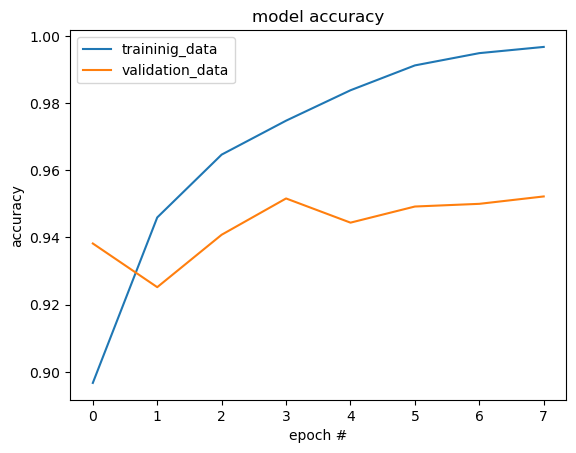

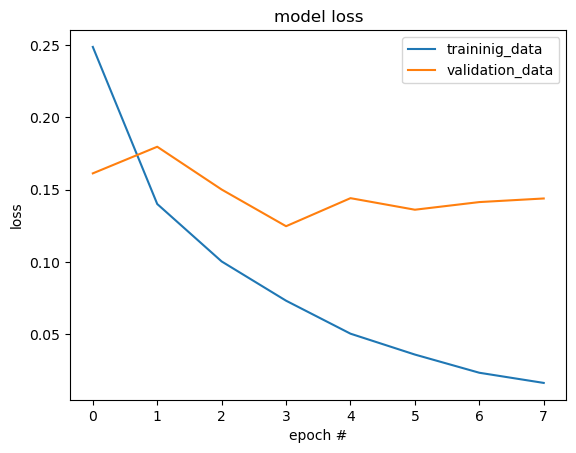

In [30]:
#============================================
# Plot the accuracy and loss curves 
#============================================
plt.plot(training.history['accuracy'], label='traininig_data')
plt.plot(training.history['val_accuracy'], label='validation_data')
plt.legend()
plt.title("model accuracy")
plt.xlabel("epoch #")
plt.ylabel("accuracy")
plt.show()

plt.plot(training.history['loss'], label='traininig_data')
plt.plot(training.history['val_loss'], label='validation_data')
plt.legend()
plt.title("model loss")
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.show()

### **5.8. Prediction for New Images**

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 1s 609ms/step
[[0.]]
              Prediction:  Cat


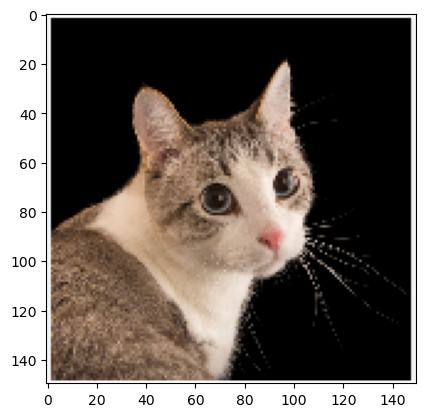

In [31]:
# put all commands at one place 
from tensorflow.keras.preprocessing import image
img = image.load_img("./image1.png",target_size=(img_width, img_height))
img_pred = img

type(img_pred)

img_pred = image.img_to_array(img_pred)  # convert from PIL image type to numpy array
print(img_pred.shape)

img_pred=np.expand_dims(img_pred, axis=0)   # since we are predicting for 1 image, hence we need to reshape the input to the model as expected by model
print(img_pred.shape)

class_predict = model_vgg.predict(img_pred)     # predict the class
print(class_predict)

if class_predict[0][0]==1:
    prediction ="Dog"
else:
    prediction ="Cat"

print("=============================================")
print('              Prediction: ',prediction)
print("=============================================")

imgplot = plt.imshow(img)
plt.show()



(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 16ms/step
[[1.]]
              Prediction:  Dog


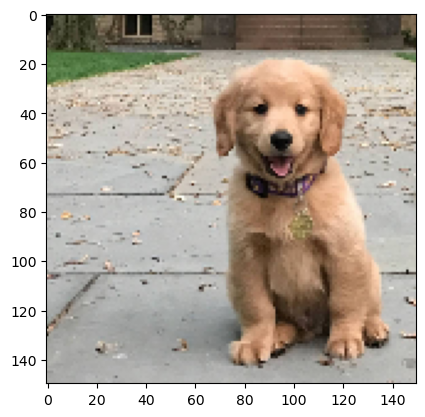

In [32]:
# put all commands at one place 
from tensorflow.keras.preprocessing import image
img = image.load_img("./image2.png",target_size=(img_width, img_height))
img_pred = img

type(img_pred)

img_pred = image.img_to_array(img_pred)  # convert from PIL image type to numpy array
print(img_pred.shape)

img_pred=np.expand_dims(img_pred, axis=0)   # since we are predicting for 1 image, hence we need to reshape the input to the model as expected by model
print(img_pred.shape)

class_predict = model_vgg.predict(img_pred)     # predict the class
print(class_predict)

if class_predict[0][0]==1:
    prediction ="Dog"
else:
    prediction ="Cat"

print("=============================================")
print('              Prediction: ',prediction)
print("=============================================")

imgplot = plt.imshow(img)
plt.show()

